In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

DATA_PATH = "/content/potato_feature_engineered_dataset.csv"
LOOK_BACK = 30
EPOCHS = 25
BATCH = 32
VAL_SPLIT = 0.1

TARGET_COL = "Modal_Price"
FEATURE_COLUMNS = None

df = pd.read_csv(DATA_PATH)
print("Loaded dataset shape:", df.shape)
print("Missing values:\n", df.isnull().sum())

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found in dataset!")

if FEATURE_COLUMNS is None:
    FEATURES = [c for c in numeric_cols if c != TARGET_COL]
else:
    FEATURES = FEATURE_COLUMNS

print("\nUsing Features:", FEATURES)
print("Using Target:", TARGET_COL)

df = df[FEATURES + [TARGET_COL]].dropna().reset_index(drop=True)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df.values)
combined = scaled

def create_sequences(data, look_back):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, :-1])
        y.append(data[i, -1])
    return np.array(X), np.array(y)

X, y = create_sequences(combined, LOOK_BACK)
print("\nSequence shapes → X:", X.shape, " y:", y.shape)

n_features = X.shape[2]

model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(LOOK_BACK, n_features)),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

early = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
history = model.fit(
    X, y,
    epochs=EPOCHS,
    batch_size=BATCH,
    validation_split=VAL_SPLIT,
    callbacks=[early],
    verbose=1
)

pred_scaled = model.predict(X)

def inverse_target(values_scaled):
    inv = []
    for v in values_scaled.reshape(-1):
        row = np.zeros(len(FEATURES) + 1)
        row[-1] = v
        inv_row = scaler.inverse_transform(row.reshape(1, -1))
        inv.append(inv_row[0, -1])
    return np.array(inv)

predictions = inverse_target(pred_scaled)
actuals = inverse_target(y.reshape(-1, 1))

output_df = pd.DataFrame({
    "Actual_Modal_Price": actuals,
    "Predicted_Modal_Price": predictions
})

print("\nFirst 10 Predictions:")
print(output_df.head(10).to_string(index=False))

output_df.to_csv("multi_feature_predictions.csv", index=False)
print("\nSaved predictions to multi_feature_predictions.csv")
model.save("multi_feature_lstm_model.h5")
print("Saved model → multi_feature_lstm_model.h5")

Loaded dataset shape: (19144, 25)
Missing values:
 State             0
District          0
Market            0
Commodity         0
Variety           0
Grade             0
Arrival_Date      0
Min_Price         0
Max_Price         0
Modal_Price       0
Commodity_Code    0
Day               0
Month             0
Year              0
DayOfWeek         0
WeekOfYear        0
Quarter           0
Lag_1             0
Lag_7             0
Lag_30            0
MA_7              0
MA_15             0
MA_30             0
Price_Spread      0
Volatility        0
dtype: int64

Using Features: ['Min_Price', 'Max_Price', 'Commodity_Code', 'Day', 'Month', 'Year', 'DayOfWeek', 'WeekOfYear', 'Quarter', 'Lag_1', 'Lag_7', 'Lag_30', 'MA_7', 'MA_15', 'MA_30', 'Price_Spread', 'Volatility']
Using Target: Modal_Price

Sequence shapes → X: (19114, 30, 17)  y: (19114,)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,105 (90.25 KB)

 Trainable params: 23,105 (90.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
538/538 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0026 - mae: 0.0352 - val_loss: 0.0017 - val_mae: 0.0315
Epoch 2/25
538/538 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0015 - mae: 0.0268 - val_loss: 0.0018 - val_mae: 0.0320
Epoch 3/25
538/538 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0015 - mae: 0.0260 - val_loss: 0.0018 - val_mae: 0.0321
Epoch 4/25
538/538 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0014 - mae: 0.0259 - val_loss: 0.0017 - val_mae: 0.0306
Epoch 5/25
538/538 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0014 - mae: 0.0257 - val_loss: 0.0017 - val_mae: 0.0310
Epoch 6/25
538/538 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0015 - mae: 0.0259 - val_loss: 0.0018 - val_mae: 0.0317
Epoch 7/25
538/538 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0014 - mae: 0.0255 - val_loss: 0.0018 - val_mae: 0.0312
Epoch 8/25
538/538 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0014 - mae: 0.0253 - val_loss: 0.0016 - val_mae: 0.0300
Epoch 9/25
538/538 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - lo


First 10 Predictions:
 Actual_Modal_Price  Predicted_Modal_Price
              250.0             300.917539
              225.0             300.228404
              250.0             292.358634
              250.0             286.924587
              250.0             288.718373
              238.0             290.281719
              250.0             293.664151
              238.0             294.415898
              231.0             295.489049
              225.0             297.693191

Saved predictions to multi_feature_predictions.csv
Saved model → multi_feature_lstm_model.h5


In [ ]:
import gradio as gr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler


def inverse_target_global(values_scaled):
    global scaler, FEATURES
    if 'scaler' not in globals() or scaler is None:
        print("Scaler not found in global scope for inverse_target_global. Re-fitting.")
        if 'df' not in globals() or df is None:
            raise RuntimeError("DataFrame 'df' not found for scaler re-initialization. Please run the first cell.")
        globals()['scaler'] = MinMaxScaler()
        globals()['scaler'].fit(df[FEATURES + [TARGET_COL]].values)

    inv = []
    for v in values_scaled.reshape(-1):
        row = np.zeros(len(FEATURES) + 1)
        row[-1] = v
        inv_row = scaler.inverse_transform(row.reshape(1, -1))
        inv.append(inv_row[0, -1])
    return np.array(inv)


def predict_prices(n_days):
    global model, scaler, df, LOOK_BACK, FEATURES, TARGET_COL

    if 'model' not in globals() or model is None:
        try:
            model = load_model("multi_feature_lstm_model.h5")
            globals()['model'] = model
            print("LSTM model loaded.")
        except Exception as e:
            print(f"Error loading model: {e}. Please ensure 'multi_feature_lstm_model.h5' exists.")
            return []

    if 'scaler' not in globals() or scaler is None or 'df' not in globals() or df is None:
        print("Scaler or DataFrame 'df' not found in global scope. Attempting to re-load and re-fit.")
        try:

            temp_df_full = pd.read_csv(DATA_PATH)
            numeric_cols = temp_df_full.select_dtypes(include=[np.number]).columns.tolist()
            current_features = FEATURES

            df_for_scaler_fit = temp_df_full[current_features + [TARGET_COL]].dropna().reset_index(drop=True)

            globals()['df'] = df_for_scaler_fit
            globals()['scaler'] = MinMaxScaler()
            globals()['scaler'].fit(df_for_scaler_fit.values)
            print("DataFrame and Scaler re-initialized.")

        except Exception as e:
            print(f"Error re-initializing scaler/DataFrame: {e}. Please ensure DATA_PATH is correct and first cell ran successfully.")
            return []

    last_known_data_df = df.tail(LOOK_BACK)
    scaled_last_known_data = scaler.transform(last_known_data_df[FEATURES + [TARGET_COL]].values)

    current_input_sequence = scaled_last_known_data[:, :-1]
    predicted_scaled_values = []

    last_known_row = df.iloc[-1]
    try:
        last_date = pd.to_datetime(f"{int(last_known_row['Year'])}-{int(last_known_row['Month'])}-{int(last_known_row['Day'])}")
    except KeyError as e:
        print(f"Date component (Year, Month, Day) missing in features for last row: {e}. Cannot generate future dates.")
        return []

    for i in range(n_days):
        input_for_model = current_input_sequence[np.newaxis, :, :]

        next_scaled_modal_price = model.predict(input_for_model, verbose=0)[0, 0]
        predicted_scaled_values.append(next_scaled_modal_price)

        next_unscaled_features_base = df[FEATURES].iloc[-1].values.copy()

        future_date = last_date + pd.Timedelta(days=i + 1)

        if 'Day' in FEATURES:
            next_unscaled_features_base[FEATURES.index('Day')] = future_date.day
        if 'Month' in FEATURES:
            next_unscaled_features_base[FEATURES.index('Month')] = future_date.month
        if 'Year' in FEATURES:
            next_unscaled_features_base[FEATURES.index('Year')] = future_date.year
        if 'DayOfWeek' in FEATURES:
            next_unscaled_features_base[FEATURES.index('DayOfWeek')] = future_date.dayofweek
        if 'WeekOfYear' in FEATURES:
            next_unscaled_features_base[FEATURES.index('WeekOfYear')] = future_date.isocalendar().week
        if 'Quarter' in FEATURES:
            next_unscaled_features_base[FEATURES.index('Quarter')] = future_date.quarter

        original_predicted_price = inverse_target_global(np.array([next_scaled_modal_price]))[0]

        if 'Lag_1' in FEATURES:
            next_unscaled_features_base[FEATURES.index('Lag_1')] = original_predicted_price

        dummy_row_for_scaling = np.zeros(len(FEATURES) + 1)
        dummy_row_for_scaling[:-1] = next_unscaled_features_base

        next_scaled_feature_vector = scaler.transform(dummy_row_for_scaling.reshape(1, -1))[0, :-1]

        current_input_sequence = np.vstack([current_input_sequence[1:], next_scaled_feature_vector])

    predicted_prices = inverse_target_global(np.array(predicted_scaled_values).reshape(-1, 1))

    return predicted_prices.tolist()


def make_prediction_ui(n_days):
    preds = predict_prices(n_days)

    df = pd.DataFrame({
        "Day": list(range(1, n_days + 1)),
        "Predicted Price": preds
    })

    plt.figure(figsize=(8,4))
    plt.plot(df["Day"], df["Predicted Price"])
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.title(f"Forecast for next {n_days} days")
    plt.tight_layout()

    return df, plt

demo = gr.Interface(
    fn=make_prediction_ui,
    inputs=gr.Slider(1, 60, step=1, value=10, label="Select number of days to predict (max 60)"),
    outputs=[
        gr.Dataframe(label="Predicted Prices Table"),
        gr.Plot(label="Prediction Graph")
    ],
    title="Commodity Price Forecasting",
    description="Choose days (1–60) and view predicted prices + graph."
)

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9f765631443de29344.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


The current public Gradio link is: [https://58a43aab37558d05f0.gradio.live](https://58a43aab37558d05f0.gradio.live)

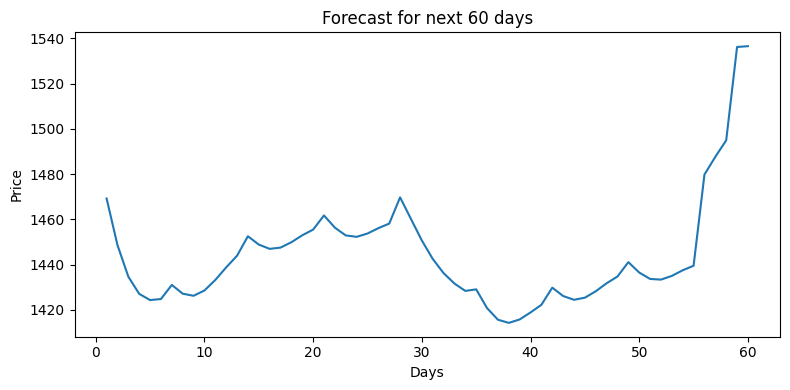

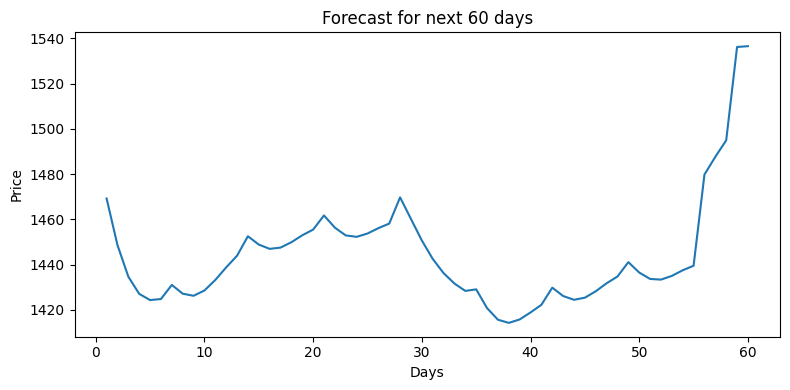

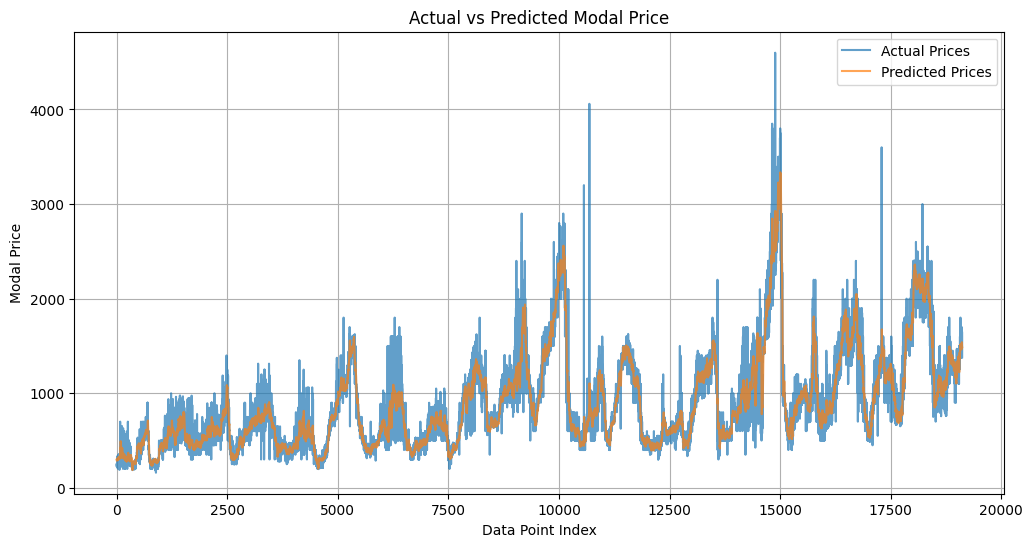

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(output_df['Actual_Modal_Price'], label='Actual Prices', alpha=0.7)
plt.plot(output_df['Predicted_Modal_Price'], label='Predicted Prices', alpha=0.7)
plt.title('Actual vs Predicted Modal Price')
plt.xlabel('Data Point Index')
plt.ylabel('Modal Price')
plt.legend()
plt.grid(True)
plt.show()


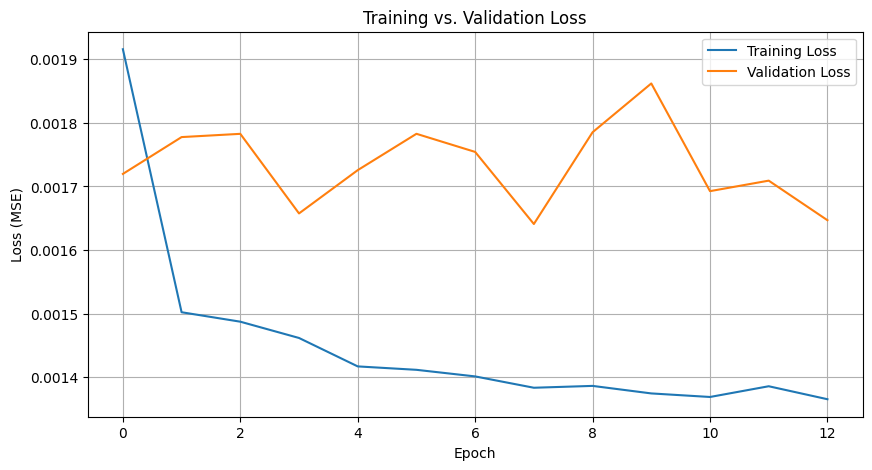

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print("\n--- Model Evaluation Metrics ---")
print(f"Final Training Loss (MSE): {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss (MSE): {history.history['val_loss'][-1]:.4f}")
print(f"Final Training MAE: {history.history['mae'][-1]:.4f}")
print(f"Final Validation MAE: {history.history['val_mae'][-1]:.4f}")


--- Model Evaluation Metrics ---
Final Training Loss (MSE): 0.0014
Final Validation Loss (MSE): 0.0018
Final Training MAE: 0.0250
Final Validation MAE: 0.0321
